In [1]:
%%capture
import numpy as np
import pandas as pd
from urbansim.models import MNLDiscreteChoiceModel

import orca
import datasources
import variables
import models

import warnings
warnings.filterwarnings("ignore")

### CONCEPTUAL
The concept of these ELCMs estimations migrates the idea of the choosers being all jobs in the table to the choosers being those jobs that were unallocated after the transition and relocation models. <br>
#### STEPS
The following steps are executed in order to estime chooser-mover elcms. Before running any model, the base jobs table is saved as “jobs_2015” in order to keep the building_id column which will correspond to the choice column. Then, the transition and relocation models are run. With a new jobs orca table where there are relocated and transitioned (new and dropped) jobs, the building_id is merged to the “jobs_2015” table based on the job_id. The new building_id column is called “building_id_2016”. This column will reveal with a value of -1 those jobs that were relocated after running the models.
Afterwards, the choosers and alternatives tables are created to estimate models at a unit-level (hh_spot_id), using the choices of the jobs as the building_id of the “jobs_2015” and those alternatives with vacant jobs spaces after the models ran. In the estimation stage, the jobs that have now a building_id_2016 == -1 will be tagged as movers. So, the fitting is done with the choosers as the jobs with `building_id_2016 == -1`, with their observed choice before being unplaced, and the alternatives are all units with vacant_jobs_soaces > 0, so buildings that after the relocation and transition model were left with space.

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

import seaborn as sb

from bokeh.io import output_notebook, show
from bokeh.plotting import Figure
from datashader.bokeh_ext import create_ramp_legend, create_categorical_legend

output_notebook()

import datashader.transfer_functions as tf

import datashader as ds
from datashader.colors import viridis

def visualize_variable(variable_name):
    p = orca.get_table('blocks').to_frame(['x', 'y', variable_name])
    
    cvs = ds.Canvas(plot_width=1000, plot_height=700)
    agg = cvs.points(p, 'x', 'y', ds.mean(variable_name))
    img = tf.set_background(tf.shade(agg, cmap=viridis),"white")
    return img

def plot_probas(proba):
    p = orca.get_table('blocks').to_frame(['x', 'y'])
    p['proba'] = proba

    cvs = ds.Canvas(plot_width=1000, plot_height=700)
    agg = cvs.points(p, 'x', 'y', ds.mean('proba'))
    img= tf.set_background(tf.shade(agg, cmap=viridis),"white")
    return img

Loading BokehJS ...

### CHOOSER MOVER

Number of jobs: 2,774,223


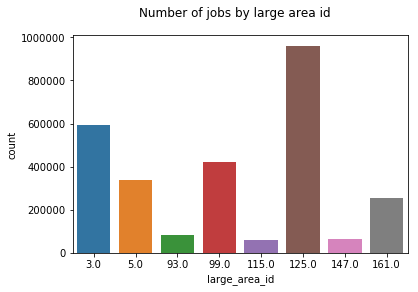

Number of unallocated jobs: 0
Number of buildings: 1,660,654


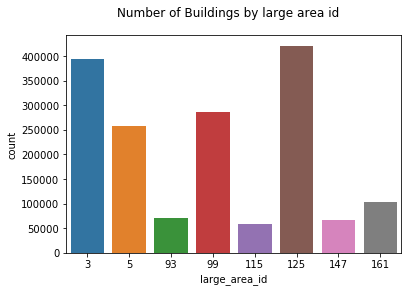

Number of Job Spaces: 1,660,654


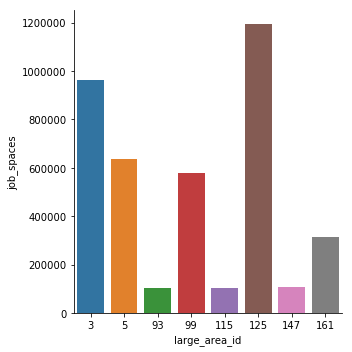

Number of Empty Buildings: 0
Number of vacant job spaces: 1,226,747.0
large_area_id
3      370125.0
5      300296.0
93      19529.0
99     155636.0
115     46414.0
125    232532.0
147     44176.0
161     58039.0
Name: vacant_job_spaces, dtype: float64


In [4]:
jobs = orca.get_table('jobs').local
print('Number of jobs: {:,}'.format(len(jobs)))
ax = sb.countplot(x='large_area_id' , data=jobs)
plt.suptitle('Number of jobs by large area id')
plt.show()
# print('jobs by large area: \n{}'.format(jobs.large_area_id.value_counts()))
print('Number of unallocated jobs: {:,}'.format(len(jobs[jobs.building_id == -1])))

bldg = orca.get_table('buildings').to_frame(['large_area_id', 'job_spaces', 'vacant_job_spaces'])
print('Number of buildings: {:,}'.format(len(bldg)))
ax = sb.countplot(x='large_area_id' , data=bldg)
plt.suptitle('Number of Buildings by large area id')
plt.show()
# print('Buildings by large area: \n{}'.format(bldg.large_area_id.value_counts()))
print('Number of Job Spaces: {:,}'.format(len(bldg)))
ax = sb.catplot(x='large_area_id' ,y= 'job_spaces', kind='bar',
                data=bldg.groupby('large_area_id').job_spaces.sum().reset_index())
plt.show()
# print('job_spaces by large area: \n{}'.format(bldg.groupby('large_area_id').job_spaces.sum()))
print('Number of Empty Buildings: {:,}'.format(len(jobs[jobs.building_id == -1])))
print('Number of vacant job spaces: {:,}\n{}'.format(bldg.vacant_job_spaces.sum(),
                                                        bldg.groupby('large_area_id').vacant_job_spaces.sum()))

In [5]:
# ADD TO THE ORCA TABLE A FIX COLUMN WITH THE BUILDING ID 2015
orca.add_column('jobs', 'building_id_2015', jobs.building_id)
orca.add_column('buildings', 'vacant_2015', bldg.vacant_job_spaces)

In [6]:
# BEFORE RUNNING THE RELOCATION AND TRANSITION MODELS THERE SHOULD NOT BE NULL VALUES IN BLDG ID 2015
orca.get_table('jobs').to_frame(['building_id_2015']).building_id_2015.isnull().sum()

0

In [7]:
# RUN TRANSITION AND RELOCATION MODELS, so next building ids will be of 2016. 
transition_semcog = ['jobs_transition_semcog']
relocation_models = ['jobs_relocation']
orca.run(transition_semcog + relocation_models, iter_vars=[2015])

Running iteration 1 with iteration value 2015
Running step 'jobs_transition_semcog'
Time to execute step 'jobs_transition_semcog': 64.77 s
Running step 'jobs_relocation'
Total currently unplaced: 1809
Agents (jobs) unplaced by relocation: 131344
Total currently unplaced: 133109
Time to execute step 'jobs_relocation': 2.84 s
Total time to execute iteration 1 with iteration value 2015: 67.60 s


Number of jobs: 2,774,533


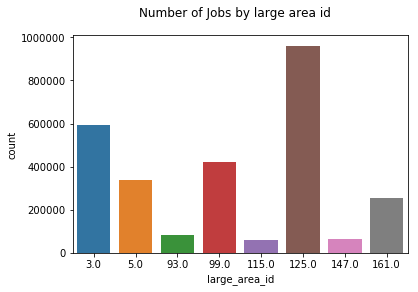

Number of unallocated jobs in 2016: 133,109
Number of buildings: 1,660,654


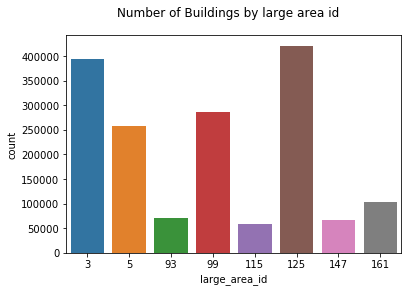

Number of Job Spaces: 1,660,654


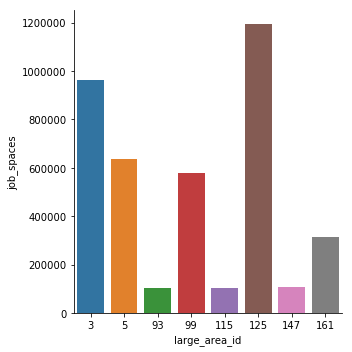

Number of Empty Buildings: 133,109
Number of vacant Job Spaces: 1,359,546.0
large_area_id
3      399465.0
5      314863.0
93      23076.0
99     174704.0
115     48863.0
125    283607.0
147     46786.0
161     68182.0
Name: vacant_job_spaces, dtype: float64


In [8]:
jobs_16 = orca.get_table('jobs').local
print('Number of jobs: {:,}'.format(len(jobs_16)))
ax = sb.countplot(x='large_area_id' , data=jobs_16)
plt.suptitle('Number of Jobs by large area id')
plt.show()
print('Number of unallocated jobs in 2016: {:,}'.format(len(jobs_16[jobs_16.building_id == -1])))

bldg_16 = orca.get_table('buildings').to_frame(['large_area_id', 'job_spaces', 'vacant_job_spaces'])
print('Number of buildings: {:,}'.format(len(bldg_16)))
ax = sb.countplot(x='large_area_id' , data=bldg_16)
plt.suptitle('Number of Buildings by large area id')
plt.show()
print('Number of Job Spaces: {:,}'.format(len(bldg_16)))
ax = sb.catplot(x='large_area_id' ,y= 'job_spaces', kind='bar',
                data=bldg_16.groupby('large_area_id').job_spaces.sum().reset_index())
plt.show()
print('Number of Empty Buildings: {:,}'.format(len(jobs_16[jobs_16.building_id == -1])))
print('Number of vacant Job Spaces: {:,}\n{}'.format(bldg_16.vacant_job_spaces.sum(),
                                                        bldg_16.groupby('large_area_id').vacant_job_spaces.sum()))

In [9]:
# Add to the 2015 Jobs table the Jobs to got unallocated
jobs_2016 = orca.get_table('jobs').to_frame(['building_id']).rename(columns = {'building_id':'building_id_16'})
jobs2 = jobs.join(jobs_2016)
print('Number of jobs that got unalloacted in 2016: {:,}'.format(len(jobs2[jobs2.building_id_16 == -1])))
print('Number of jobs deleted in 2016: {:,}'.format(len(jobs2[jobs2.building_id_16.isnull()])))
jobs2.building_id_16.fillna(-1, inplace=True)
print('Finally, all relocated/transitioned jobs that will be the choosers in the ELCMS: {:,}'.format(len(jobs2[jobs2.building_id_16 == -1])))

Number of jobs that got unalloacted in 2016: 131,300
Number of jobs deleted in 2016: 1,499
Finally, all relocated/transitioned jobs that will be the choosers in the ELCMS: 132,799


In [10]:
jobs2[jobs2.building_id_16 == -1].sector_id.value_counts()

10    22770
16    15137
14    14045
9     13867
12    13626
5     12969
3     11077
17     8614
4      6778
15     3791
6      3029
2      2687
8      2250
11     1766
7       238
1        99
13       44
18       12
Name: sector_id, dtype: int64

In [30]:
# orca.get_table('building_types').to_frame(['building_type_name','generic_building_type_name'])

## UNIT-LEVEL

In [12]:
# Getting all the variables from the ELCM clustvars models
import yaml
import os
path = 'configs/elcm_unit_level/'
elcm_files = os.listdir(path)
elcm_vars = []
for filen in elcm_files:
    with open(path + filen) as f:
        store = yaml.safe_load(f)
        elcm_vars.extend(store['model_expression'])
elcm_vars = set(elcm_vars)

In [13]:
# Alternatives and choosers
elcm_vars2 = list(elcm_vars) + ['non_residential_sqft', 'zone_id', 'building_type_id', 'parcel_id',
                               'job_spaces','vacant_job_spaces']
alternatives = orca.get_table('buildings').to_frame(elcm_vars2)
# alternatives = alternatives[alternatives.non_residential_sqft > 0]
jobs = orca.get_table('jobs').local
choosers = jobs2.copy()

Disaggregating ln_empden_9 to buildings from zones
Disaggregating ln_empden_8 to buildings from zones
Disaggregating ln_empden_5 to buildings from zones
Disaggregating ln_empden_4 to buildings from zones
Disaggregating ln_empden_3 to buildings from zones
Disaggregating popden to buildings from zones
Disaggregating prop_office_buildings to buildings from zones
Disaggregating ln_empden_14 to buildings from zones
Disaggregating ln_popden to buildings from zones
Disaggregating empden to buildings from zones
Disaggregating ln_empden_6 to buildings from zones
Disaggregating prop_medical_buildings to buildings from zones
Disaggregating ln_empden_2 to buildings from zones
Disaggregating ln_empden_11 to buildings from zones
Disaggregating ln_empden_10 to buildings from zones
Disaggregating ln_empden_17 to buildings from zones
Disaggregating ln_empden_16 to buildings from zones
Disaggregating prop_industrial_buildings to buildings from zones
Disaggregating ln_empden to buildings from zones


In [14]:
### Unit-level alternatives: adding spot_id
buildings = orca.get_table('buildings').to_frame(['vacant_job_spaces'])
units_reloca16 = choosers[choosers.building_id_16 == -1].groupby('building_id').count()[['building_id_16']]
buildings = buildings.join(units_reloca16).fillna(0)
buildings['vacant_job_spaces'] = buildings.vacant_job_spaces - buildings.building_id_16
remaining_job_capac = buildings[buildings.vacant_job_spaces > 0].vacant_job_spaces
vacant_job_spots = np.repeat(remaining_job_capac.index, remaining_job_capac.values.astype(int))

occupied_job_spots = choosers[choosers.building_id_16 == -1].building_id
occupied_job_spots = pd.DataFrame(occupied_job_spots)
occupied_job_spots['occupied'] = 0
relocated_jobs_spots = choosers[(choosers.building_id != -1) & (choosers.building_id_16 != -1)].building_id
relocated_jobs_spots = pd.DataFrame(relocated_jobs_spots)
relocated_jobs_spots['occupied'] = 1
used_jobs_spots = pd.concat([relocated_jobs_spots, occupied_job_spots])

next_id = used_jobs_spots.index.max() + 1
vacant_idx = np.arange(next_id, next_id + len(vacant_job_spots)) 
vacant_job_spots = pd.Series(vacant_job_spots, index = vacant_idx)
vacant_job_spots = pd.DataFrame(vacant_job_spots)
vacant_job_spots['occupied'] = 0

job_spots = pd.concat([used_jobs_spots, vacant_job_spots])
job_spots.index.name = 'job_spot_id'

choosers['job_spot_id'] = choosers.index.values

alternatives = pd.merge(job_spots, alternatives, left_on='building_id', right_index=True)

print job_spots.occupied.value_counts()

1    2641424
0    1873145
Name: occupied, dtype: int64


In [15]:
occupied_job_spots.head()

,building_id,occupied
26,2212493,0
67,2296585,0
92,2296585,0
107,2299049,0
116,2299672,0


In [16]:
choosers[choosers.building_id_16 == -1].head()

,home_based_status,sector_id,large_area_id,sqft,semcog_id,building_id,building_id_16,job_spot_id
26,0,2,125.0,1000,1803,2212493,-1.0,26
67,0,16,125.0,100,1810,2296585,-1.0,67
92,0,16,125.0,100,1810,2296585,-1.0,92
107,0,10,125.0,250,1811,2299049,-1.0,107
116,0,4,125.0,250,1813,2299672,-1.0,116


In [17]:
orca.add_table('choosers', choosers)
orca.add_table('alternatives', alternatives)

In [18]:
alts_fit_filters = '(occupied == 0)'

def register_elcm_model(dcm, sector_id):
    dcm.choice_column = 'building_id'
    dcm.alts_predict_filters = 'vacant_job_spaces > 0'
    dcm.choosers_predict_filters = '(sector_id == {}) & (home_based_status == 0)'.format(str(sector_id))
    dcm.to_yaml('./configs/choosermover/elcm/elcm{}.yaml'.format(str(sector_id)))

In [19]:
choosers[(choosers.building_id_16 == -1) & (choosers.home_based_status == 1) ]

,home_based_status,sector_id,large_area_id,sqft,semcog_id,building_id,building_id_16,job_spot_id
8306,1,5,93.0,0,432,7078976,-1.0,8306
9524,1,5,93.0,0,728,7115835,-1.0,9524
9622,1,5,93.0,0,772,7099591,-1.0,9622
40465,1,18,93.0,0,6665,7048075,-1.0,40465
45946,1,5,93.0,0,7381,7056430,-1.0,45946
45987,1,5,93.0,0,7387,7063015,-1.0,45987
50656,1,9,93.0,0,7914,7029245,-1.0,50656
71849,1,2,125.0,0,11335,2311164,-1.0,71849
84103,1,3,125.0,0,13414,2289814,-1.0,84103
112895,1,5,125.0,0,17352,2494997,-1.0,112895


## Sector 14: Health Care & Social Assistance

Null Log-liklihood: -80092.514
Log-liklihood at convergence: -59183.052
Log-liklihood Ratio: 0.261

+------------------------------------+-------------+------------+----------+
| Component                          | Coefficient | Std. Error | T-Score  |
+------------------------------------+-------------+------------+----------+
| st_is_medical                      |    0.161    |   0.001    | 168.547  |
| st_is_retail                       |    -0.105   |   0.005    | -20.705  |
| st_b_ln_non_residential_sqft       |    -0.725   |   0.003    | -215.613 |
| st_zones_ln_empden_14              |    0.106    |   0.002    |  56.111  |
| st_zones_prop_industrial_buildings |    -0.112   |   0.005    | -23.911  |
+------------------------------------+-------------+------------+----------+
None


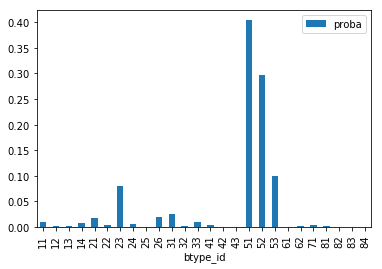

In [27]:
sector_id = 14
specification = ['st_is_medical', 
                 'st_is_retail', 
               'st_b_ln_non_residential_sqft', 
               'st_zones_ln_empden_14',
#                'st_jobs_within_30_min', 
#                'st_zones_popden',
                 'st_zones_prop_industrial_buildings',
#                 'st_building_age'
                ]

choosers_fit_filter = "(building_id_16 == -1) & (sector_id == {}) & (home_based_status == 0)".format(str(sector_id))
dcm = MNLDiscreteChoiceModel(model_expression=specification,
                             sample_size=300,
                             probability_mode='single_chooser',
                             choice_mode='aggregate',
#                              estimation_sample_size=1000,
                             choosers_fit_filters=choosers_fit_filter,
                            alts_fit_filters = alts_fit_filters)

dcm.fit(choosers, alternatives, 'job_spot_id')

print dcm.report_fit()
dcm.alts_predict_filters = 'vacant_job_spaces > 0'
proba = dcm.probabilities(jobs, alternatives, filter_tables=True).reset_index().set_index('alternative_id')[0]
pd.DataFrame({'proba':proba, 'btype_id':alternatives.building_type_id}).groupby('btype_id').sum().plot.bar()

In [28]:
#Register the model to configs dir
register_elcm_model(dcm, sector_id)

## Sector 6: Transportation & Warehousing

In [36]:
cols = alternatives.columns
# [c for c in cols if 'building_type_id_is_' in c]
cols

Index([u'building_id', u'occupied', u'building_type_id',
       u'non_residential_sqft', u'parcel_id', u'st_zones_ln_empden_9',
       u'st_zones_ln_empden_8', u'st_b_ln_non_residential_sqft',
       u'st_zones_ln_empden_5', u'st_zones_ln_empden_4',
       u'st_zones_ln_empden_3', u'st_zones_popden', u'st_stories',
       u'st_zones_prop_office_buildings', u'st_zones_ln_empden_14',
       u'st_zones_ln_popden', u'st_is_retail', u'st_is_tcu',
       u'st_zones_empden', u'vacant_job_spaces', u'st_building_age',
       u'st_zones_ln_empden_6', u'st_is_office',
       u'st_zones_prop_medical_buildings', u'st_zones_ln_empden_2',
       u'job_spaces', u'st_jobs_within_30_min', u'zone_id',
       u'st_zones_ln_empden_11', u'st_zones_ln_empden_10',
       u'st_zones_ln_empden_17', u'st_zones_ln_empden_16',
       u'st_building_type_id_is_26', u'st_zones_prop_industrial_buildings',
       u'st_zones_ln_empden', u'st_is_medical', u'st_is_industrial'],
      dtype='object')

Null Log-liklihood: -17202.608
Log-liklihood at convergence: -12388.229
Log-liklihood Ratio: 0.280

+------------------------------+-------------+------------+---------+
| Component                    | Coefficient | Std. Error | T-Score |
+------------------------------+-------------+------------+---------+
| st_is_tcu                    |    0.202    |   0.004    |  56.618 |
| st_b_ln_non_residential_sqft |    -0.321   |   0.007    | -44.190 |
| st_zones_ln_empden_6         |    0.177    |   0.003    |  64.443 |
| st_stories                   |    -0.079   |   0.004    | -22.360 |
| st_building_age              |    -0.324   |   0.024    | -13.450 |
+------------------------------+-------------+------------+---------+
None


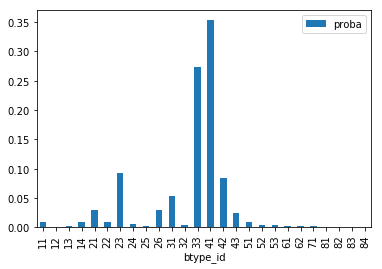

In [38]:
sector_id = 6
specification = ['st_is_tcu', 
               'st_b_ln_non_residential_sqft', 
               'st_zones_ln_empden_6',
#                'st_jobs_within_30_min', 
#                'st_zones_popden',
                 'st_stories',
                'st_building_age']

choosers_fit_filter = "(building_id_16 == -1) & (sector_id == {}) & (home_based_status == 0)".format(str(sector_id))
dcm = MNLDiscreteChoiceModel(model_expression=specification,
                             sample_size=300,
                             probability_mode='single_chooser',
                             choice_mode='aggregate',
#                              estimation_sample_size=5000,
                             choosers_fit_filters=choosers_fit_filter,
                            alts_fit_filters = alts_fit_filters)

dcm.fit(choosers, alternatives, 'job_spot_id')

print dcm.report_fit()
dcm.alts_predict_filters = 'vacant_job_spaces > 0'
proba = dcm.probabilities(jobs, alternatives).reset_index().set_index('alternative_id')[0]
pd.DataFrame({'proba':proba, 'btype_id':alternatives.building_type_id}).groupby('btype_id').sum().plot.bar()

In [39]:
#Register the model to configs dir
register_elcm_model(dcm, sector_id)

## Sector 2: Construction

Null Log-liklihood: -15286.137
Log-liklihood at convergence: -13757.082
Log-liklihood Ratio: 0.100

+------------------------------+-------------+------------+----------+
| Component                    | Coefficient | Std. Error | T-Score  |
+------------------------------+-------------+------------+----------+
| st_is_industrial             |    0.079    |   0.004    |  20.967  |
| st_b_ln_non_residential_sqft |    -1.052   |   0.007    | -154.979 |
| st_zones_ln_empden_2         |    0.179    |   0.007    |  27.512  |
| st_building_age              |    -0.424   |   0.024    | -17.660  |
+------------------------------+-------------+------------+----------+
None


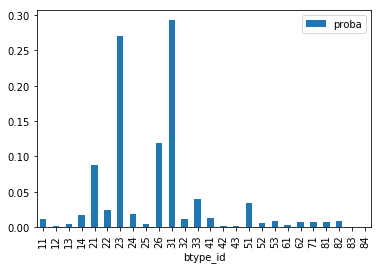

In [46]:
sector_id = 2
specification = [
#                 'st_is_office', 
               'st_is_industrial', 
               'st_b_ln_non_residential_sqft', 
               'st_zones_ln_empden_2',
#                'st_jobs_within_30_min', 
#                'st_zones_popden',
                'st_building_age']

choosers_fit_filter = "(building_id_16 == -1) & (sector_id == {}) & (home_based_status == 0)".format(str(sector_id))
dcm = MNLDiscreteChoiceModel(model_expression=specification,
                             sample_size=300,
                             probability_mode='single_chooser',
                             choice_mode='aggregate',
#                              estimation_sample_size=5000,
                             choosers_fit_filters=choosers_fit_filter,
                            alts_fit_filters = alts_fit_filters)

dcm.fit(choosers, alternatives, 'job_spot_id')

print dcm.report_fit()
dcm.alts_predict_filters = 'vacant_job_spaces > 0'
proba = dcm.probabilities(jobs, alternatives).reset_index().set_index('alternative_id')[0]
pd.DataFrame({'proba':proba, 'btype_id':alternatives.building_type_id}).groupby('btype_id').sum().plot.bar()

In [47]:
#Register the model to configs dir
register_elcm_model(dcm, sector_id)

## Sector 3: Manufacturing

Null Log-liklihood: -63083.834
Log-liklihood at convergence: -52322.001
Log-liklihood Ratio: 0.171

+------------------------------------+-------------+------------+---------+
| Component                          | Coefficient | Std. Error | T-Score |
+------------------------------------+-------------+------------+---------+
| st_is_industrial                   |    0.202    |   0.002    |  93.116 |
| st_b_ln_non_residential_sqft       |    -0.239   |   0.005    | -48.386 |
| st_zones_ln_empden_3               |    0.245    |   0.004    |  61.424 |
| st_jobs_within_30_min              |    -0.243   |   0.012    | -20.474 |
| st_zones_prop_industrial_buildings |    -0.042   |   0.002    | -24.622 |
| st_building_age                    |    -0.269   |   0.013    | -21.445 |
+------------------------------------+-------------+------------+---------+
None


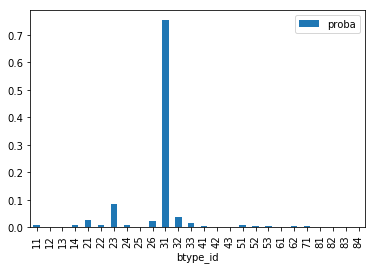

In [51]:
sector_id = 3
specification = ['st_is_industrial', 
               'st_b_ln_non_residential_sqft', 
               'st_zones_ln_empden_3',
               'st_jobs_within_30_min', 
#                'st_zones_ln_empden',
                 'st_zones_prop_industrial_buildings',
                'st_building_age', 
#                'st_is_retail'
                ]

choosers_fit_filter = "(building_id_16 == -1) & (sector_id == {}) & (home_based_status == 0)".format(str(sector_id))
dcm = MNLDiscreteChoiceModel(model_expression=specification,
                             sample_size=300,
                             probability_mode='single_chooser',
                             choice_mode='aggregate',
#                              estimation_sample_size=5000,
                             choosers_fit_filters=choosers_fit_filter,
                            alts_fit_filters = alts_fit_filters)

dcm.fit(choosers, alternatives, 'job_spot_id')

print dcm.report_fit()
dcm.alts_predict_filters = 'vacant_job_spaces > 0'
proba = dcm.probabilities(jobs, alternatives).reset_index().set_index('alternative_id')[0]
pd.DataFrame({'proba':proba, 'btype_id':alternatives.building_type_id}).groupby('btype_id').sum().plot.bar()

In [52]:
#Register the model to configs dir
register_elcm_model(dcm, sector_id)

## Sector 4: WholeSale Trade

Null Log-liklihood: -38626.015
Log-liklihood at convergence: -33592.485
Log-liklihood Ratio: 0.130

+------------------------------+-------------+------------+----------+
| Component                    | Coefficient | Std. Error | T-Score  |
+------------------------------+-------------+------------+----------+
| st_is_office                 |    -0.062   |   0.004    | -16.551  |
| st_is_industrial             |    0.077    |   0.003    |  28.796  |
| st_b_ln_non_residential_sqft |    -0.593   |   0.005    | -110.602 |
| st_zones_ln_empden_4         |    0.274    |   0.005    |  55.473  |
| st_building_type_id_is_26    |    -0.208   |   0.012    | -17.187  |
| st_zones_ln_empden           |    -0.190   |   0.013    | -14.716  |
| st_building_age              |    -0.350   |   0.015    | -23.483  |
+------------------------------+-------------+------------+----------+
None


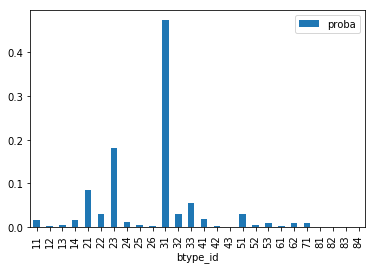

In [77]:
sector_id = 4
specification = ['st_is_office',
                'st_is_industrial', 
#                  'st_is_medical',
               'st_b_ln_non_residential_sqft', 
               'st_zones_ln_empden_4',
                 'st_building_type_id_is_26',
#                'st_jobs_within_30_min', 
#                'st_zones_ln_popden',
                 'st_zones_ln_empden',
                'st_building_age',
#                 'st_zones_prop_medical_buildings',
                ]

choosers_fit_filter = "(building_id_16 == -1) & (sector_id == {}) & (home_based_status == 0)".format(str(sector_id))
dcm = MNLDiscreteChoiceModel(model_expression=specification,
                             sample_size=300,
                             probability_mode='single_chooser',
                             choice_mode='aggregate',
#                              estimation_sample_size=5000,
                             choosers_fit_filters=choosers_fit_filter,
                            alts_fit_filters = alts_fit_filters)

dcm.fit(choosers, alternatives, 'job_spot_id')

print dcm.report_fit()
dcm.alts_predict_filters = 'vacant_job_spaces > 0'
proba = dcm.probabilities(jobs, alternatives).reset_index().set_index('alternative_id')[0]
pd.DataFrame({'proba':proba, 'btype_id':alternatives.building_type_id}).groupby('btype_id').sum().plot.bar()

In [78]:
#Register the model to configs dir
register_elcm_model(dcm, sector_id)

## Sector 5: Retail

Null Log-liklihood: -73892.502
Log-liklihood at convergence: -57956.572
Log-liklihood Ratio: 0.216

+------------------------------+-------------+------------+---------+
| Component                    | Coefficient | Std. Error | T-Score |
+------------------------------+-------------+------------+---------+
| st_is_retail                 |    0.390    |   0.004    | 106.683 |
| st_b_ln_non_residential_sqft |    0.294    |   0.005    |  58.461 |
| st_zones_ln_empden_5         |    0.280    |   0.004    |  66.176 |
| st_zones_ln_empden_8         |    -0.030   |   0.003    |  -8.580 |
| st_zones_ln_empden           |    -0.258   |   0.012    | -22.406 |
| st_zones_ln_popden           |    0.150    |   0.009    |  16.349 |
| st_building_age              |    -0.399   |   0.011    | -35.911 |
+------------------------------+-------------+------------+---------+
None


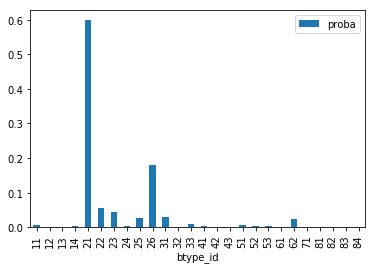

In [80]:
sector_id = 5
specification = ['st_is_retail', 
               'st_b_ln_non_residential_sqft', 
               'st_zones_ln_empden_5',
                 'st_zones_ln_empden_8',
               'st_zones_ln_empden', 
               'st_zones_ln_popden',
                'st_building_age'
                ]

choosers_fit_filter = "(building_id_16 == -1) & (sector_id == {}) & (home_based_status == 0)".format(str(sector_id))
dcm = MNLDiscreteChoiceModel(model_expression=specification,
                             sample_size=300,
                             probability_mode='single_chooser',
                             choice_mode='aggregate',
#                              estimation_sample_size=5000,
                             choosers_fit_filters=choosers_fit_filter,
                            alts_fit_filters = alts_fit_filters)

dcm.fit(choosers, alternatives, 'job_spot_id')

print dcm.report_fit()
dcm.alts_predict_filters = 'vacant_job_spaces > 0'
proba = dcm.probabilities(jobs, alternatives).reset_index().set_index('alternative_id')[0]
pd.DataFrame({'proba':proba, 'btype_id':alternatives.building_type_id}).groupby('btype_id').sum().plot.bar()

In [81]:
#Register the model to configs dir
register_elcm_model(dcm, sector_id)

## Sector 8 : Information

Null Log-liklihood: -12810.695
Log-liklihood at convergence: -11725.576
Log-liklihood Ratio: 0.085

+------------------------------+-------------+------------+---------+
| Component                    | Coefficient | Std. Error | T-Score |
+------------------------------+-------------+------------+---------+
| st_is_office                 |    0.077    |   0.005    |  15.700 |
| st_b_ln_non_residential_sqft |    -0.143   |   0.007    | -19.219 |
| st_zones_ln_empden_8         |    0.096    |   0.003    |  36.278 |
| st_jobs_within_30_min        |    0.099    |   0.025    |  3.956  |
| st_stories                   |    -0.031   |   0.002    | -16.375 |
+------------------------------+-------------+------------+---------+
None


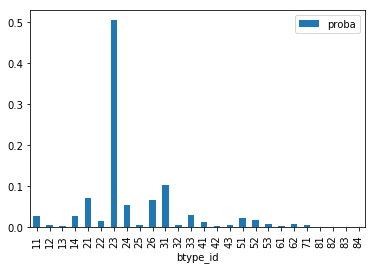

In [91]:
sector_id = 8
specification = ['st_is_office', 
               'st_b_ln_non_residential_sqft', 
               'st_zones_ln_empden_8',
#                  'st_zones_ln_empden_5',
               'st_jobs_within_30_min', 
#                'st_zones_popden',
#                 'st_zones_prop_industrial_buildings',
                 'st_stories'
                ]

choosers_fit_filter = "(building_id_16 == -1) & (sector_id == {}) & (home_based_status == 0)".format(str(sector_id))
dcm = MNLDiscreteChoiceModel(model_expression=specification,
                             sample_size=300,
                             probability_mode='single_chooser',
                             choice_mode='aggregate',
#                              estimation_sample_size=5000,
                             choosers_fit_filters=choosers_fit_filter,
                            alts_fit_filters = alts_fit_filters)

dcm.fit(choosers, alternatives, 'job_spot_id')

print dcm.report_fit()
dcm.alts_predict_filters = 'vacant_job_spaces > 0'
proba = dcm.probabilities(jobs, alternatives).reset_index().set_index('alternative_id')[0]
pd.DataFrame({'proba':proba, 'btype_id':alternatives.building_type_id}).groupby('btype_id').sum().plot.bar()

In [92]:
#Register the model to configs dir
register_elcm_model(dcm, sector_id)

## Sector 9: Finance & Insurance

Null Log-liklihood: -77731.148
Log-liklihood at convergence: -67278.456
Log-liklihood Ratio: 0.134

+------------------------------+-------------+------------+----------+
| Component                    | Coefficient | Std. Error | T-Score  |
+------------------------------+-------------+------------+----------+
| st_is_office                 |    0.156    |   0.002    |  73.079  |
| st_b_ln_non_residential_sqft |    -0.533   |   0.004    | -122.185 |
| st_stories                   |    -0.019   |   0.001    | -19.798  |
| st_zones_ln_empden_9         |    0.211    |   0.003    |  62.852  |
| st_zones_ln_popden           |    0.194    |   0.008    |  24.896  |
| st_zones_ln_empden           |    -0.235   |   0.010    | -22.704  |
| st_building_age              |    -0.486   |   0.011    | -45.976  |
+------------------------------+-------------+------------+----------+
None


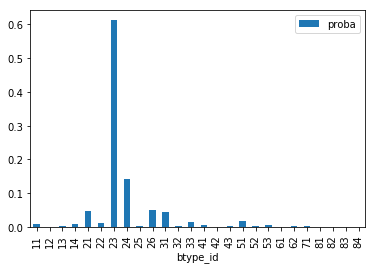

In [94]:
sector_id = 9
specification = ['st_is_office', 
               'st_b_ln_non_residential_sqft',
                 'st_stories',
               'st_zones_ln_empden_9',
#                  'st_zones_ln_empden_11',
#                'st_jobs_within_30_min', 
               'st_zones_ln_popden',
                 'st_zones_ln_empden',
                'st_building_age']

choosers_fit_filter = "(building_id_16 == -1) & (sector_id == {}) & (home_based_status == 0)".format(str(sector_id))
dcm = MNLDiscreteChoiceModel(model_expression=specification,
                             sample_size=300,
                             probability_mode='single_chooser',
                             choice_mode='aggregate',
#                              estimation_sample_size=5000,
                             choosers_fit_filters=choosers_fit_filter,
                            alts_fit_filters = alts_fit_filters)

dcm.fit(choosers, alternatives, 'job_spot_id')

print dcm.report_fit()
dcm.alts_predict_filters = 'vacant_job_spaces > 0'
proba = dcm.probabilities(jobs, alternatives).reset_index().set_index('alternative_id')[0]
pd.DataFrame({'proba':proba, 'btype_id':alternatives.building_type_id}).groupby('btype_id').sum().plot.bar()

In [95]:
#Register the model to configs dir
register_elcm_model(dcm, sector_id)

## Sector 10: Professional, Scientific and Technical Services

Null Log-liklihood: -129829.497
Log-liklihood at convergence: -115798.899
Log-liklihood Ratio: 0.108

+------------------------------+-------------+------------+---------+
| Component                    | Coefficient | Std. Error | T-Score |
+------------------------------+-------------+------------+---------+
| st_is_office                 |    0.064    |   0.002    |  41.673 |
| st_b_ln_non_residential_sqft |    -0.002   |   0.003    |  -0.775 |
| st_stories                   |    -0.035   |   0.001    | -60.065 |
| st_zones_ln_empden_10        |    0.270    |   0.002    | 111.739 |
| st_zones_ln_popden           |    0.104    |   0.007    |  15.442 |
| st_zones_ln_empden           |    -0.379   |   0.007    | -51.996 |
| st_building_age              |    -0.345   |   0.008    | -43.639 |
+------------------------------+-------------+------------+---------+
None


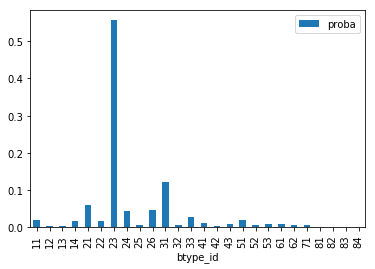

In [97]:
sector_id = 10
specification = ['st_is_office', 
               'st_b_ln_non_residential_sqft',
                 'st_stories',
               'st_zones_ln_empden_10',
#                'st_jobs_within_30_min', 
               'st_zones_ln_popden',
                 'st_zones_ln_empden',
                'st_building_age']

choosers_fit_filter = "(building_id_16 == -1) & (sector_id == {}) & (home_based_status == 0)".format(str(sector_id))
dcm = MNLDiscreteChoiceModel(model_expression=specification,
                             sample_size=300,
                             probability_mode='single_chooser',
                             choice_mode='aggregate',
#                              estimation_sample_size=5000,
                             choosers_fit_filters=choosers_fit_filter,
                            alts_fit_filters = alts_fit_filters)

dcm.fit(choosers, alternatives, 'job_spot_id')

print dcm.report_fit()
dcm.alts_predict_filters = 'vacant_job_spaces > 0'
proba = dcm.probabilities(jobs, alternatives).reset_index().set_index('alternative_id')[0]
pd.DataFrame({'proba':proba, 'btype_id':alternatives.building_type_id}).groupby('btype_id').sum().plot.bar()

In [98]:
#Register the model to configs dir
register_elcm_model(dcm, sector_id)

## Sector 11: Management of Companies and Enterprises

Null Log-liklihood: -10032.953
Log-liklihood at convergence: -7045.626
Log-liklihood Ratio: 0.298

+------------------------------+-------------+------------+---------+
| Component                    | Coefficient | Std. Error | T-Score |
+------------------------------+-------------+------------+---------+
| st_is_office                 |    0.082    |   0.006    |  12.999 |
| st_b_ln_non_residential_sqft |    0.422    |   0.011    |  38.887 |
| st_zones_ln_empden_11        |    0.097    |   0.002    |  39.800 |
| st_jobs_within_30_min        |    0.537    |   0.047    |  11.380 |
| st_zones_ln_empden           |    -0.555   |   0.025    | -22.156 |
| st_building_age              |    -0.599   |   0.030    | -19.757 |
+------------------------------+-------------+------------+---------+
None


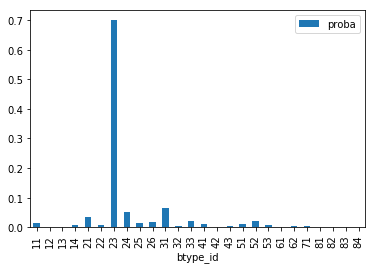

In [100]:
sector_id = 11
specification = ['st_is_office', 
               'st_b_ln_non_residential_sqft', 
               'st_zones_ln_empden_11',
               'st_jobs_within_30_min', 
#                'st_zones_popden',
                 'st_zones_ln_empden',
                'st_building_age']

choosers_fit_filter = "(building_id_16 == -1) & (sector_id == {}) & (home_based_status == 0)".format(str(sector_id))
dcm = MNLDiscreteChoiceModel(model_expression=specification,
                             sample_size=300,
                             probability_mode='single_chooser',
                             choice_mode='aggregate',
#                              estimation_sample_size=5000,
                             choosers_fit_filters=choosers_fit_filter,
                            alts_fit_filters = alts_fit_filters)

dcm.fit(choosers, alternatives, 'job_spot_id')

print dcm.report_fit()
dcm.alts_predict_filters = 'vacant_job_spaces > 0'
proba = dcm.probabilities(jobs, alternatives).reset_index().set_index('alternative_id')[0]
pd.DataFrame({'proba':proba, 'btype_id':alternatives.building_type_id}).groupby('btype_id').sum().plot.bar()

In [101]:
#Register the model to configs dir
register_elcm_model(dcm, sector_id)

## Sector 12: Administrative and Support and Waste Managemen

Null Log-liklihood: -10032.953
Log-liklihood at convergence: -7045.626
Log-liklihood Ratio: 0.298

+------------------------------+-------------+------------+---------+
| Component                    | Coefficient | Std. Error | T-Score |
+------------------------------+-------------+------------+---------+
| st_is_office                 |    0.082    |   0.006    |  12.999 |
| st_b_ln_non_residential_sqft |    0.422    |   0.011    |  38.887 |
| st_zones_ln_empden_11        |    0.097    |   0.002    |  39.800 |
| st_jobs_within_30_min        |    0.537    |   0.047    |  11.380 |
| st_zones_ln_empden           |    -0.555   |   0.025    | -22.156 |
| st_building_age              |    -0.599   |   0.030    | -19.757 |
+------------------------------+-------------+------------+---------+
None


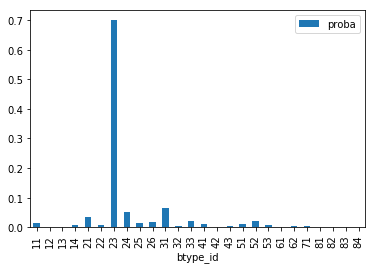

In [100]:
sector_id = 11
specification = ['st_is_office', 
               'st_b_ln_non_residential_sqft', 
               'st_zones_ln_empden_11',
               'st_jobs_within_30_min', 
#                'st_zones_popden',
                 'st_zones_ln_empden',
                'st_building_age']

choosers_fit_filter = "(building_id_16 == -1) & (sector_id == {}) & (home_based_status == 0)".format(str(sector_id))
dcm = MNLDiscreteChoiceModel(model_expression=specification,
                             sample_size=300,
                             probability_mode='single_chooser',
                             choice_mode='aggregate',
#                              estimation_sample_size=5000,
                             choosers_fit_filters=choosers_fit_filter,
                            alts_fit_filters = alts_fit_filters)

dcm.fit(choosers, alternatives, 'job_spot_id')

print dcm.report_fit()
dcm.alts_predict_filters = 'vacant_job_spaces > 0'
proba = dcm.probabilities(jobs, alternatives).reset_index().set_index('alternative_id')[0]
pd.DataFrame({'proba':proba, 'btype_id':alternatives.building_type_id}).groupby('btype_id').sum().plot.bar()

In [101]:
#Register the model to configs dir
register_elcm_model(dcm, sector_id)

## Sector 16: Arts, Entertainment & Recreation

Null Log-liklihood: -86172.746
Log-liklihood at convergence: -67681.082
Log-liklihood Ratio: 0.215

+------------------------------+-------------+------------+----------+
| Component                    | Coefficient | Std. Error | T-Score  |
+------------------------------+-------------+------------+----------+
| st_is_retail                 |    0.421    |   0.004    | 116.995  |
| st_building_type_id_is_26    |    -0.011   |   0.001    |  -9.938  |
| st_stories                   |    -0.006   |   0.001    |  -5.625  |
| st_b_ln_non_residential_sqft |    -0.544   |   0.005    | -118.519 |
| st_zones_ln_empden_16        |    0.175    |   0.002    |  79.413  |
| st_zones_popden              |    -0.107   |   0.007    | -15.457  |
| st_building_age              |    -0.467   |   0.009    | -52.853  |
+------------------------------+-------------+------------+----------+
None


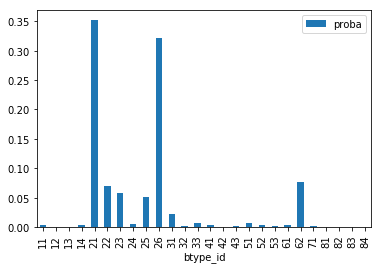

In [105]:
sector_id = 16
specification = [
    'st_is_retail', 
               'st_building_type_id_is_26', 
                 'st_stories',
               'st_b_ln_non_residential_sqft', 
               'st_zones_ln_empden_16',
#                'st_jobs_within_30_min', 
               'st_zones_popden',
                'st_building_age']

choosers_fit_filter = "(building_id_16 == -1) & (sector_id == {}) & (home_based_status == 0)".format(str(sector_id))
dcm = MNLDiscreteChoiceModel(model_expression=specification,
                             sample_size=300,
                             probability_mode='single_chooser',
                             choice_mode='aggregate',
#                              estimation_sample_size=5000,
                             choosers_fit_filters=choosers_fit_filter,
                            alts_fit_filters = alts_fit_filters)

dcm.fit(choosers, alternatives, 'job_spot_id')

print dcm.report_fit()
dcm.alts_predict_filters = 'vacant_job_spaces > 0'
proba = dcm.probabilities(jobs, alternatives).reset_index().set_index('alternative_id')[0]
pd.DataFrame({'proba':proba, 'btype_id':alternatives.building_type_id}).groupby('btype_id').sum().plot.bar()

In [106]:
#Register the model to configs dir
register_elcm_model(dcm, sector_id)

## Sector 17: Other Services

Null Log-liklihood: -48932.750
Log-liklihood at convergence: -45777.609
Log-liklihood Ratio: 0.064

+--------------------------------+-------------+------------+----------+
| Component                      | Coefficient | Std. Error | T-Score  |
+--------------------------------+-------------+------------+----------+
| st_is_retail                   |    0.095    |   0.003    |  29.144  |
| st_b_ln_non_residential_sqft   |    -0.616   |   0.004    | -172.760 |
| st_zones_ln_empden_17          |    0.180    |   0.005    |  36.358  |
| st_zones_empden                |    -0.026   |   0.001    | -19.565  |
| st_zones_prop_office_buildings |    -0.050   |   0.003    | -17.868  |
+--------------------------------+-------------+------------+----------+
None


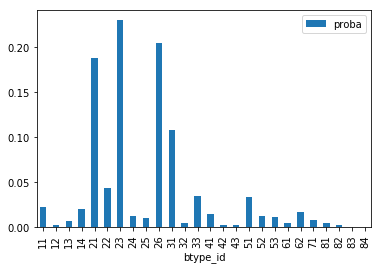

In [109]:
sector_id = 17
specification = ['st_is_retail', 
#                'st_is_office', 
               'st_b_ln_non_residential_sqft', 
               'st_zones_ln_empden_17',
#                'st_jobs_within_30_min', 
#                'st_zones_popden',
                 'st_zones_empden',
                 'st_zones_prop_office_buildings']

choosers_fit_filter = "(building_id_16 == -1) & (sector_id == {}) & (home_based_status == 0)".format(str(sector_id))
dcm = MNLDiscreteChoiceModel(model_expression=specification,
                             sample_size=300,
                             probability_mode='single_chooser',
                             choice_mode='aggregate',
#                              estimation_sample_size=5000,
                             choosers_fit_filters=choosers_fit_filter,
                            alts_fit_filters = alts_fit_filters)

dcm.fit(choosers, alternatives, 'job_spot_id')

print dcm.report_fit()
dcm.alts_predict_filters = 'vacant_job_spaces > 0'
proba = dcm.probabilities(jobs, alternatives).reset_index().set_index('alternative_id')[0]
pd.DataFrame({'proba':proba, 'btype_id':alternatives.building_type_id}).groupby('btype_id').sum().plot.bar()

In [110]:
#Register the model to configs dir
register_elcm_model(dcm, sector_id)